<a href="https://colab.research.google.com/github/bulutirm/RealAndFakeFaceDetection/blob/main/Real_and_Fake_Face_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from urllib.request import urlopen

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dir_path = '/content/drive/MyDrive/Real and Fake Detection'

In [5]:
target_size = (224, 224)

waste_labels = {'training_real' : 0, 'training_fake' : 1}

In [6]:
def load_datasets(path):

  x = []
  labels = []

  image_paths = sorted(list(paths.list_images(path)))

  for image_path in image_paths:
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    x.append(img)
    label = image_path.split(os.path.sep)[-2]
    labels.append(waste_labels[label])

  x, labels = shuffle(x, labels, random_state = 42)

  print(f"X boyutu: {np.array(x).shape}")
  print(f"Label sınıf sayısı: {len(np.unique(labels))} Gözlem sayısı: {len(labels)}")

  return x, labels 

In [7]:
x, labels = load_datasets(dir_path)

X boyutu: (2041, 224, 224, 3)
Label sınıf sayısı: 2 Gözlem sayısı: 2041


In [8]:
input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
print(input_shape)

(224, 224, 3)


In [9]:
def visualize_img(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(10):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=2)[n]==1][0].title())
    plt.axis('off')

In [10]:
#Train veri seti için bir generator tanımlıyoruz
train = ImageDataGenerator(horizontal_flip = True,
                           validation_split = 0.2,
                           rescale = 1./255,
                           shear_range = 0.2,
                           zoom_range = 0.2,
                           width_shift_range = 0.1,
                           height_shift_range = 0.1)

#Test veri seti için bir generator tanımlıyoruz.
test = ImageDataGenerator(rescale = 1/255,
                          validation_split = 0.1)

In [11]:
train_generator = train.flow_from_directory(directory = dir_path,
                                             target_size = (target_size),
                                             class_mode = 'categorical',
                                             subset = 'training')

test_generator = test.flow_from_directory(directory = dir_path,
                                          target_size = (target_size),
                                          batch_size = 251,
                                          class_mode = 'categorical',
                                          subset = 'validation')

Found 1633 images belonging to 2 classes.
Found 204 images belonging to 2 classes.


In [12]:
#modelleme
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', 
                 input_shape = (input_shape), activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=2, activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0

In [14]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])

In [15]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
            ModelCheckpoint(filepath='mymodel.h5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False, verbose=1)]

In [16]:
history = model.fit_generator(generator=train_generator,
                              epochs=100,
                              validation_data=test_generator,
                              callbacks=callbacks,
                              workers=4,
                              steps_per_epoch=1633//32,
                              validation_steps=204//32)

Epoch 1/100
51/51 [==============================] - ETA: 0s - loss: 0.6970 - precision: 0.5191 - recall: 0.5191 - acc: 0.5191
Epoch 1: val_loss improved from inf to 0.69318, saving model to mymodel.h5
51/51 [==============================] - 46s 680ms/step - loss: 0.6970 - precision: 0.5191 - recall: 0.5191 - acc: 0.5191 - val_loss: 0.6932 - val_precision: 0.4853 - val_recall: 0.4853 - val_acc: 0.4853
Epoch 2/100
51/51 [==============================] - ETA: 0s - loss: 0.6933 - precision: 0.5328 - recall: 0.5328 - acc: 0.5328
Epoch 2: val_loss improved from 0.69318 to 0.69202, saving model to mymodel.h5
51/51 [==============================] - 34s 657ms/step - loss: 0.6933 - precision: 0.5328 - recall: 0.5328 - acc: 0.5328 - val_loss: 0.6920 - val_precision: 0.5294 - val_recall: 0.5294 - val_acc: 0.5294
Epoch 3/100
51/51 [==============================] - ETA: 0s - loss: 0.6920 - precision: 0.5276 - recall: 0.5276 - acc: 0.5276
Epoch 3: val_loss improved from 0.69202 to 0.69164, savin

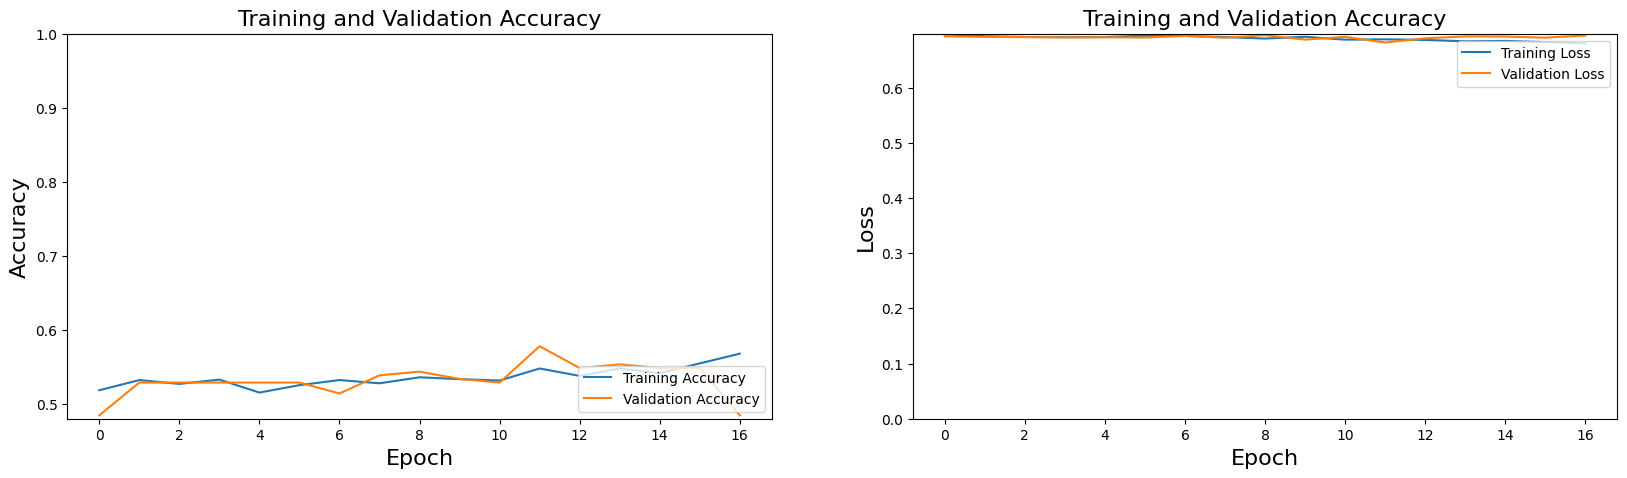

In [17]:
#Accuracy Grafiği

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy', fontsize=16)

#Loss grafiği
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Accuracy', fontsize=16)

plt.show()

In [18]:
loss, precision, recall, acc = model.evaluate(test_generator, batch_size=32)

1/1 [==============================] - 2s 2s/step - loss: 0.6946 - precision: 0.4853 - recall: 0.4853 - acc: 0.4853


In [19]:
print("\nTest accuracy: %.1f%%" % (100.0 * acc))
print("\nTest loss: %.1f%%" % (100.0 * loss))
print("\nTest precision: %.1f%%" % (100.0 * precision))
print("\nTest recall: %.1f%%" % (100.0 * recall))


Test accuracy: 48.5%

Test loss: 69.5%

Test precision: 48.5%

Test recall: 48.5%


In [20]:
#Clasification Report
x_test, y_test = test_generator.next()

y_pred = model.predict(x_test)

y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test, axis=1)

7/7 [==============================] - 0s 20ms/step


In [21]:
y_pred

array([1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1])

In [22]:
target_names = list(waste_labels.keys())

In [24]:
from sklearn.metrics import classification_report

In [25]:
print(classification_report(y_test, y_pred, target_names=target_names))

               precision    recall  f1-score   support

training_real       0.38      0.15      0.21        96
training_fake       0.51      0.79      0.62       108

     accuracy                           0.49       204
    macro avg       0.44      0.47      0.41       204
 weighted avg       0.45      0.49      0.43       204



In [34]:
#Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(8,6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label', fontweight="bold")
  plt.xlabel('Predicted label', fontweight="bold")

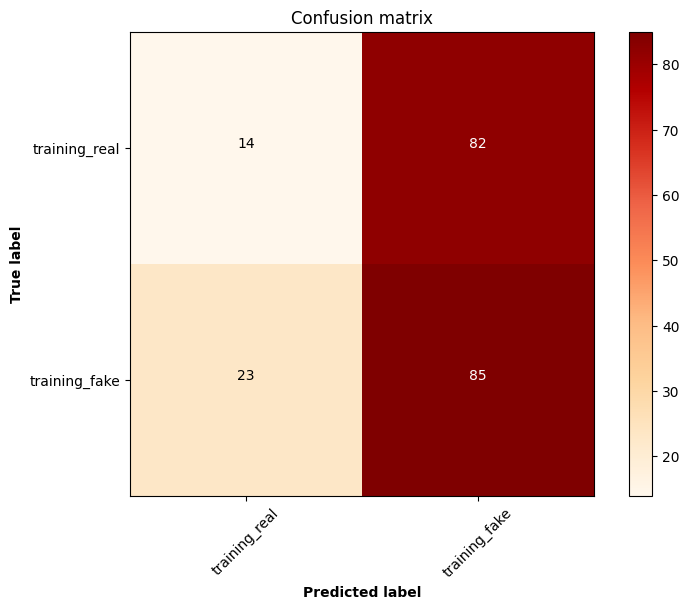

In [35]:
plot_confusion_matrix(cm, waste_labels.keys(),
                      title='Confusion matrix',
                      cmap=plt.cm.OrRd)

In [36]:
def model_testing(path):
  img = image.load_img(path, target_size=(target_size))
  img = image.img_to_array(img, dtype=np.uint8)
  img = np.array(img) / 255.0
  p = model.predict(img.reshape(1, 224, 224, 3))
  predicted_class = np.argmax(p[0])

  return img, p, predicted_class
     